<a href="https://colab.research.google.com/github/kaiqizhao/760/blob/master/pgm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilistic Graphical Models

In this colab, we are going to learn how to build PGMs for

*   Topic modeling
*   Clustering

## Topic modeling

The most famous topic model is Latent Dirichlet Allocation [1].

[1] Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.


LDA assumes that the topic distribution for a document follows a Dirichlet distribution $Dir(\alpha_1, \alpha_2, ..., \alpha_K)$. With concentration $\alpha_i<1$, the content (i.e., words) within a document is forced to centered at some particular topics, making distinguishable topic distribution for the documents. The graphical representation of LDA is:

![Graphical representation of LDA](https://drive.google.com/uc?export=view&id=1SWyj8YpAOxp9xifV28_KqyxT9QT6h_bs)


Now, we implement LDA with tensorflow-probability. First, we need to import some packages.

In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

import numpy as np

import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.INFO) # show the training information

Then, we are going to build the LDA model. First of all, we define the prior distribution of topics, i.e., $\theta \sim Dir(\alpha)$. 

Note that, the concentration parameters in Dirichlet distribution are all positive $\alpha_i>0$. Usually, this constraint may make the optimization more complex. So, instead of direclty learn $\alpha_i$, we can learn the "logit" $l_{\alpha_i}$ of $\alpha$, such that
$$\alpha_i = softplus(l_{\alpha_i}) = \log{(1+e^{l_{\alpha_i}})} >0 $$

The learnable parameters are not constrained now, because $l_{\alpha_i}$ can take any real value.

In [0]:
def prior(num_topics):
  # prior parameters
  logit_concentration = tf.get_variable(
        "logit_alpha",
        shape=[1, num_topics],
        initializer=tf.initializers.constant(
            np.log(np.expm1(0.1))))
  concentration = tf.nn.softplus(logit_concentration)
  
  # define the distribution of p(\theta)
  def p_theta():
    return tfd.Dirichlet(concentration=concentration,
                         name="prior")
  return p_theta

Next, given the topic distribution of a document, we want to model the word distribution of the documents, i.e., $$p(w_1, ..., w_{N_d}|\theta_d)=\prod_{n=1}^{N_d}\sum_z{p(w_n|z_n)p(z_n|\theta_d)}$$

The probability $p(z|\theta)$ actually equals to $\theta$. The probability $p(w|z)$ is the topic-word distribution, which is $\beta_{z, w}$ in the figure. Note that, $\theta_d$ is a $K$-dimensional vector, where $K$ is the number of topics. $\beta$ is a matrix with lines correspond to topics and columns correspond to word. So, this can be reformuated to $p(w_1, ..., w_{N_d}|\theta_d)\sim \theta_d^T\beta$.

Because each row in $\beta$ is the word distribution of a topic, we have $\sum_v{\beta_{z,v}}=1$. Similar to $\alpha$, to allow unconstrained learning on the parameters.

$$ \beta_{z, v} = softmax(l_{\beta_{z,v}}) = \frac{e^{l_{\beta_{z,v}}}}{\sum_{v'}{e^{l_{\beta_{z,v'}}}}} $$

In [0]:
def likelihood(num_topics, num_words):  
  # topic_word parameters
  topic_word_logit = tf.get_variable(
      "logit_phi",
      shape=[num_topics, num_words],
      initializer=tf.glorot_normal_initializer())
  topic_word = tf.nn.softmax(topic_word_logit, axis=-1)
  
  # define the distribution of p(w1, w2, ..., wn|\theta)
  def p_w_theta(topics):
    word_probs = tf.matmul(topics, topic_word)
    return tfd.OneHotCategorical(probs=word_probs,
                                 name="words")
  
  return p_w_theta, topic_word

For simplicity, we define $p(w|\theta_d)$ as a one-hot categorical distribution. Although it is multi-hot in practice, it makes not difference when computing the log-likelihood. The merits of using one-hot categorical distribution here is that we can define and use the distribution as a function over all the documents, without the need to consider the different lengths of documents. To wrap up, we have:

In [0]:
def lda(num_topics, num_words):
  p_theta = prior(num_topics)
  p_w_theta, topic_word = likelihood(num_topics, num_words)
  return p_theta, p_w_theta, topic_word

We have already built the LDA mode. Next is to learn the parameters. Here, we use variational inference. 

Variational inference uses another tractable (easy to compute) distribution to approximate the original distribution. The joint probability and posteriors of LDA are difficult to compute because the concentration parameters $\alpha$ of topic distributions are shared across different documents and the topic distribution in a document is shared across all the words within the document.
$$p(D, \theta)=\prod_d{p(\theta_d|\alpha)}p(\mathbf{w}_d|\theta_d)=\prod_d{p(\theta_d|\alpha)}\prod_n^{N_d}p(w_n|z_n)p(z_n|\theta_d)$$

To overcome this, we can "localize" the topic distribution -- we set different concentration parameters for each document. Specifically, we can use $q(\theta;\gamma_d)$ to approximate the posterior $p(\theta|d)\propto p(\theta_d|\alpha)p(\mathbf{w}_d|\theta_d)$, where $\gamma_d$ is document-specific.

With this approximation, the evidence lower bound can be derived as:

$$
\begin{aligned}
\log{p(d)}&=\log{\int_{\theta}p(\theta|\alpha)p(\mathbf{w}_d|\theta)d\theta} \\
&=\log{\int_{\theta}{q(\theta|\gamma_d)\frac{p(\theta|\alpha)p(\mathbf{w}_d|\theta)}{q(\theta|\gamma_d)}}d\theta} \\
&\ge \int_\theta{q(\theta|\gamma_d)\log{\frac{p(\theta|\alpha)p(\mathbf{w}_d|\theta)}{q(\theta|\gamma_d)}}d\theta} \\
&=E_q{[p(\mathbf{w}_d|\theta)]}+E_q{[p(\theta|\alpha)]-E_q{[q(\theta|\gamma_d)]}} \\
&=E_q{[p(\mathbf{w}_d|\theta)]} - KL(q(\theta|\gamma_d)||p(\theta|\alpha))
\end{aligned}
$$

The first part is the reconstruction likelihood. We can use numeric approximation to estimate its value. Suppose we draw $S$ samples from $q(\theta|\gamma_d)$, the expectation of $p(\mathbf{w}_d|\theta)$ will be $\frac{1}{S}\sum_{s=1}^S\theta_s^T\beta$, where $\theta_s \sim q(\theta|\gamma_d)$. The KL-divergence between the variational distribution and the prior is a regularization term to force the information shared globally.

So, our training process has the following steps. For each training document, we


1.   Sample $S$ samples from $q(\theta|\gamma_d)$
2.   Compute the reconstruction likelihood $\frac{1}{S}\sum_{s=1}^S\theta_s^T\beta$
3.   Compute the KL-divergence $KL(q(\theta|\gamma_d)||p(\theta|\alpha))$
4.   Compute the edvicence lower bound (ELBO):  $ELBO=\frac{1}{S}\sum_{s=1}^S\theta_s^T\beta - KL(q(\theta|\gamma_d)||p(\theta|\alpha))$
5.  Minimize loss = - ELBO using gradient descent


The remaining problem is how to design $q(\theta|\gamma_d)$. We notice that this is document-specific, so we can use a simple neural network which takes the words as input and output a topic distribution. Here, we use a single  fully connected layer with a softplus activation function to generate the concentration parameters of a Dirichlet distribution, then we model the variational distribution as $q(\theta|f(\mathbf{w}_d))$, where $f(\cdot)$ is the single neural network.




In [0]:
def variational(num_topics):
  f = tf.keras.layers.Dense(
          num_topics,
          activation=tf.nn.softplus,
          kernel_initializer=tf.glorot_normal_initializer())

  def q_z_w(bag_of_words):
    return tfd.Dirichlet(concentration=tf.clip_by_value(f(bag_of_words), 
                                                        1e-4, 1e4),
                         name="posterior")
  return q_z_w

Then, we write the variational inference algorithm using the aforementioned five steps

In [0]:
def model_vi(features, labels, mode, params, config):
  del labels, config  # we are not using any labels and specific config
  
  # first, we initialize the model and the variational distribution
  p_theta, p_w_theta, topic_word = lda(params["num_topics"], features.shape[1])
  q_z_w = variational(params["num_topics"])
 
  # Step 1. sample topics from variational distribution
  # for simplicity, we only use 1 sample here
  topics_posterior = q_z_w(features)  
  topics = topics_posterior.sample()
  
  # Step2. reconstruct the document
  reconstruction = p_w_theta(topics)
  reconstruction = reconstruction.log_prob(features)

  # Step 3. compute KL-divergence
  topics_prior = p_theta()
  kl = tfd.kl_divergence(topics_posterior, topics_prior)
  
  # Step 4. compute evidence lower bound
  elbo = reconstruction - kl
  avg_elbo = tf.reduce_mean(input_tensor=elbo)
  
  # Step 5. optimize loss
  loss = -avg_elbo  
  optimizer = tf.train.AdamOptimizer(params["learning_rate"])  
  global_step = tf.train.get_or_create_global_step()
  
  return tf.estimator.EstimatorSpec(
      mode=mode,
      loss=loss,
      train_op=optimizer.minimize(loss, 
                             global_step=global_step),
      eval_metric_ops={
          "elbo": tf.metrics.mean(elbo),
          "reconstruction": tf.metrics.mean(reconstruction),
          "kl": tf.metrics.mean(kl)
      },
  )


With the model function, we can build an estimator for learning the parameters

In [0]:
params = {'num_topics':3, 'learning_rate':1e-3}

estimator = tf.estimator.Estimator(
      model_vi,
      params=params,
      config=tf.estimator.RunConfig(
          model_dir='/tmp/lda/',
          save_checkpoints_steps=1000,
      ),
  )

I0723 08:19:47.398668 140344126609280 estimator.py:209] Using config: {'_model_dir': '/tmp/lda/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa42848c400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


To this end, we have our model ready. Before training, we need to generate data. Here, we use the 20newsgroup documents in three classes, i.e., religion, computer graphics and space.

In [0]:
def get_data():
  global vocab
  categories = [
    'talk.religion.misc',
    'comp.graphics',
    'sci.space']
  data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=0)
  vectorizer = CountVectorizer(max_df=0.5, min_df=2, stop_words='english')
  features = vectorizer.fit_transform(data.data).astype(np.float32)
  vocab = vectorizer.get_feature_names()
  labels = data.target
  
  # build a tensorflow dataset from the numpy array
  dataset = tf.data.Dataset.range(features.shape[0])
  dataset = dataset.shuffle(features.shape[0]).repeat()
  
  # define numpy function to convert sparse vectors of documents to dense vector
  # this is because scipy use sparse matrix to store the documents.
  def get_row_py_func(idx):
    def get_row_python(idx_py):
      return np.squeeze(np.array(features[idx_py].todense()), axis=0)
    py_func = tf.py_func(
              get_row_python, [idx], tf.float32, stateful=False)
    py_func.set_shape((len(vocab),))
    return py_func

  dataset = dataset.map(get_row_py_func)
  return dataset

# the tensorflow estimator needs a function to generate input in mini-batches.
def next_batch():
  dataset = get_data()
  dataset = dataset.batch(32).prefetch(32)
  return tf.data.make_one_shot_iterator(dataset).get_next()

We are ready to go! Let's feed the data into the estimator.

In [0]:
MAX_Epochs = 20
STEPS_IN_EPOCH = 1000
for epoch in range(MAX_Epochs):
  estimator.train(next_batch, steps=STEPS_IN_EPOCH)

W0723 08:19:47.501004 140344126609280 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
I0723 08:19:47.520282 140344126609280 twenty_newsgroups.py:247] Downloading 20news dataset. This may take a few minutes.
I0723 08:19:47.525372 140344126609280 twenty_newsgroups.py:80] Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)
W0723 08:19:59.408016 140344126609280 deprecation.py:323] From <ipython-input-8-41b15b4c2032>:23: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2

We have trained an LDA model. Let's check the topics.

In [0]:
from scipy.special import softmax
concentration = estimator.get_variable_value('logit_alpha')
concentration = np.log(np.exp(np.squeeze(concentration, axis=0))+1)
topic_rank = np.argsort(-concentration)

topic_words = estimator.get_variable_value('logit_phi')
topics = softmax(topic_words)
top_words = np.argsort(-topics, axis=1)

for topic in topic_rank[:3]:
  l = [vocab[word] for word in top_words[topic, :20]]
  print('topic {}:'.format((topic+1)), ' '.join(l))

topic 2: com space article just nasa posting like don people nntp host university know think god does time world jesus gov
topic 3: graphics image data images file files ftp available program use software format university information pub color space 3d version package
topic 1: word time people new greek way don said com like space judas christian used did reply field does matthew mr


## Gaussian Mixture Model

Gaussian mixture models (GMMs) are often used for modeling data that comes from several components (clusters). GMM assumes there are $K$ components (corresponding to $K$ clusters) and each component is a Gaussian distribution with unknown mean and variance. The likelihood of a data point given a set of paramters $\Phi=\{\phi,\mu,\Sigma\}$ is:
$$ p(x;\Phi) = \sum_{c=1}^K{p(x;\mu_c, \Sigma_c)p(c;\phi)}$$

$p(c;\phi)$ is often called mixture distribution parameterized by $\phi$, while the normal distributions $p(x;\mu_c, \Sigma_c)$ for a particular component is called component distribution.
Let's first define the model using tensorflow-probability. 


In [0]:
# define the learnable parameters of the GMM model
def gmm(K, dim):
  # mixture parameters
  logit_mix = tf.get_variable(
        "logit_mix",
        shape=[K],
        dtype=np.float64,
        initializer=tf.glorot_normal_initializer())
  
  # mean parameters for each component
  mu = tf.get_variable(
        "mu",
        shape=[K, dim],
        dtype=np.float64,
        initializer=tf.glorot_normal_initializer())
  
  # covariance parameters
  logit_Sigma = tf.get_variable(
      name="logit_Sigma", shape=[K, dim],
      dtype=np.float64,
      initializer=tf.glorot_normal_initializer())

  return logit_mix, mu, logit_Sigma

Then, we want to define the log-joint probability of the model follows the above equation. In tensorflow-probability, there is a convenience class **MixtureSameFamily** for defining the mixture models.

In [0]:
def log_joint(observations, mix, mu, logit_Sigma):
  g = tfd.MixtureSameFamily(
      # set the mixture distribution p(c)
      mixture_distribution=tfd.Categorical(probs=mix),
      # set the component distribution as normal(mu, Sigma)
      components_distribution=tfd.MultivariateNormalDiag(
          loc=mu,
          scale_diag=logit_Sigma),
          name="gmm")
  return tf.reduce_sum(g.log_prob(observations))  

In this colab, we use Markov chain Monte Carlo (MCMC) to infer the posterior distribution $p(\Phi|X)\propto p(X, \Phi)$. To achieve this, we can use **functools.partial** to make a log_joint function that has fixed observations $X$. By doing this, the log_joint function is now a function of the parameters $\Phi$, and is the unnormalized posterior distribution.

In [0]:
import functools
tfb = tfp.bijectors

def gmm_mcmc(inital_states, observations):
  posterior_log_prob = functools.partial(log_joint, observations)  
  
  [logit_mix, mu, logit_Sigma], _ = tfp.mcmc.sample_chain(
      num_results=2000,
      num_burnin_steps=500,
      current_state=initial_state,
      kernel=tfp.mcmc.TransformedTransitionKernel(
          # Hamiltonian Monte Carlo is a special case of MCMC
          inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
              target_log_prob_fn=posterior_log_prob,
              step_size=0.065,
              num_leapfrog_steps=5),
              # bijector is used to convert the problem to unconstraint problem
              bijector = [tfb.SoftmaxCentered(),
                          tfb.Identity(), 
                          tfb.Softplus()]
      )
  )
  
  return logit_mix, mu, logit_Sigma

To this end, we have implemented the MCMC algorithm to draw samples of the parameters. Next, we prepare data to evaluate our model. Here, we use the same dataset we used in clustering.

In [0]:
from sklearn.datasets import *

n_samples = 500
mix = make_blobs(n_samples=n_samples, centers=4,
                       cluster_std=0.60, random_state=0)
circles = make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
moons = make_moons(n_samples=n_samples, noise=.05)

datasets = [mix, circles, moons]
n_clusters = [4, 2, 2]

Because for each dataset, we build different GMMs with different number of components, we need to define a function to reset the computation graph of tensorflow for each dataset.

In [0]:
def reset_session():
  tf.reset_default_graph()
  global sess
  try:
    sess.close()
  except:
    pass
  sess = tf.InteractiveSession(config=tf.ConfigProto())

Everything is ready. We next proceed to apply the GMM models to the three datasets to generate clusters. To compute the cluster label, we find the component $c$ that maximizes $p(x;\mu_c, \Sigma_c)p(c;\phi)$

mix_pro:  [0.24965452 0.25122149 0.2506223  0.24850168]
mean_loc:  [[-1.23967548  7.84777935]
 [ 0.94655807  4.32932225]
 [ 1.9681994   0.85618503]
 [-1.62939662  2.8539183 ]]
mean_logit_Sigma:  [[0.53954792 0.58083448]
 [0.59587727 0.59822694]
 [0.64113299 0.59080503]
 [0.57338158 0.65349173]]
mix_pro:  [0.5 0.5]
mean_loc:  [[ 0.50371665  0.13138246]
 [ 0.32250784 -0.24447506]]
mean_logit_Sigma:  [[1. 1.]
 [1. 1.]]
mix_pro:  [0.5 0.5]
mean_loc:  [[1.95798241 0.26370045]
 [1.00977929 0.24870205]]
mean_logit_Sigma:  [[1. 1.]
 [1. 1.]]


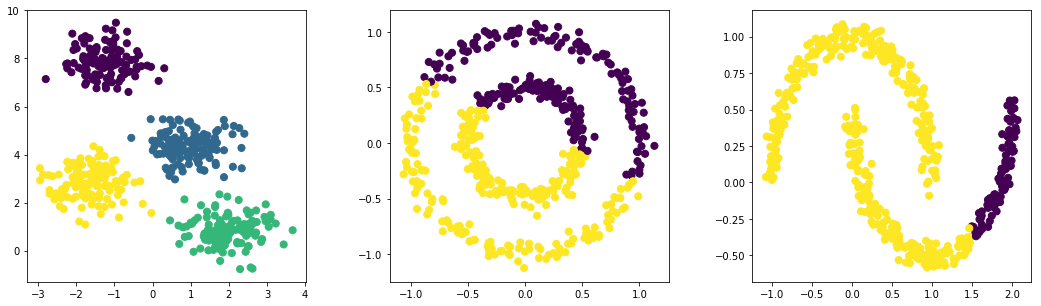

In [0]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.sparse import diags

plt.figure(figsize=(18, 5))
plt.subplots_adjust(wspace=.3, hspace=.3)
plot_num = 1

for ds, k in zip(datasets, n_clusters):
  # reset computation graph
  reset_session()
  observations, y = ds
  
  # initial values of the parameters
  initial_state = [
        tf.fill([k], value=np.array(1. / k, dtype=np.float64)),
        tf.constant(value=observations[np.random.randint(observations.shape[0], 
                           size=k), :], dtype=np.float64),
        tf.fill([k, observations.shape[1]], value=np.array(1, dtype=np.float64))
    ]

  # initialize the GMM model
  mix_prob, mu, logit_Sigma = gmm(k, observations.shape[1])
  
  # run MCMC algorithm to generate a set of samples of the mixture probability,
  # mean and covariance of the components
  mix_prob, mu, logit_Sigma = gmm_mcmc(initial_state, observations)

  # avarage the values from all the samples
  mean_mix_probs = tf.reduce_mean(mix_prob, axis=0)
  mean_loc = tf.reduce_mean(mu, axis=0)
  mean_logit_Sigma = tf.reduce_mean(logit_Sigma, axis=0)

  [
      mean_mix_probs_,
      mean_loc_,
      mean_logit_Sigma_,
      mix_prob_,
      mu_,
      logit_Sigma_,
  ] = sess.run([
      mean_mix_probs,
      mean_loc,
      mean_logit_Sigma,
      mix_prob,
      mu,
      logit_Sigma,
  ])
  
  print('mix_pro: ', mean_mix_probs_)  
  print('mean_loc: ', mean_loc_)
  print('mean_logit_Sigma: ', mean_logit_Sigma_)
  
  labels = []
  for o in range(observations.shape[0]):
    # compute the label for each observation
    l = [np.log(mean_mix_probs_[c]) + 
                multivariate_normal.logpdf(x=observations[o, :],
                             mean=mean_loc_[c, :], 
                             cov=diags(mean_logit_Sigma_[c, :]).todense())
                for c in range(k)]
    labels.append(np.argmax(np.array(l)))
    
  plt.subplot(1, len(datasets), plot_num)
  plt.scatter(observations[:, 0], observations[:, 1], c=labels, s=50, cmap='viridis')
  plot_num += 1